In [93]:
import os
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.linear_model import SGDClassifier

In [94]:
mnist=fetch_openml("mnist_784")
X, y= mnist["data"], mnist["target"]

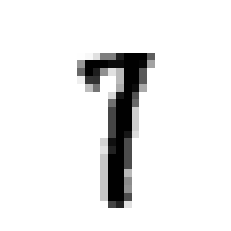

In [95]:
%matplotlib inline
some_digit=X[370].reshape(28,28)

plt.imshow(some_digit, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [96]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [97]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Training a binary classifier

In [98]:
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

In [99]:
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [100]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [101]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold, y_train_fold=X_train[train_index], y_train_5[train_index]
    X_test_fold, y_test_fold=X_train[test_index], y_train_5[test_index]
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.97085
0.96775
0.93255


In [102]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y=y_train_5, cv=3, scoring='accuracy')

array([0.97085, 0.96775, 0.93255])

In [103]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm=confusion_matrix(y_train_5, y_train_pred)

In [104]:
from sklearn.metrics import precision_score, recall_score, f1_score

Precision and recall:
1. When the predictor predicts a positive instant, a correct prediction implies true positive and an incorrect prediction implies a false positive. The probability that a positive prediction being correct is called precision. We can define precision as: 
    Precision = (True positive cases)/(Predicted positive cases) = (True positive) / (True positive + False positive)
2. On the other hand, when a positive instant is subjected to the predictor, a correct prediction implies a true positive and an incorrect prediction implies a false negative. The probability of a positive instant being correctly predicted is called sensitivity or recall. We define sensitivity as:
    Sensitivity = (True positive cases) / (Actual positive cases) = (True positive) / (True positive + false negative)

In [105]:
print(precision_score(y_train_5, y_train_pred))
precision=cm[1][1]/(cm[1][1] + cm[0][1])
print(precision)

print(recall_score(y_train_5, y_train_pred))
recall=cm[1][1]/(cm[1][1] + cm[1][0])
print(recall)

0.7292069632495164
0.7292069632495164
0.8345323741007195
0.8345323741007195


So when our predictor predicts a positive instant, it is correct only 59% of the times, while it can only correctly identify 86% of the positive instant as postive. Not so much for a good predictor. 

We can combine these scores into a single score called f1 score. We want both scores to be as large as possible, we define f1=2(1/(precision) + 1/(recall))^(-1)

In [106]:
print(f1_score(y_train_5, y_train_pred))
f1=2* (1/precision + 1/recall)**(-1)
print((f1))

0.7783225806451614
0.7783225806451614


In [ ]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

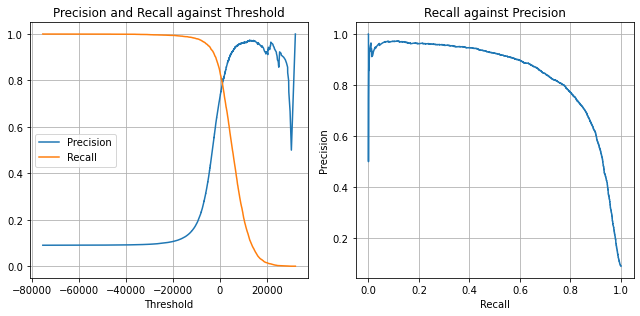

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.5))
axes=axes.flatten()

axes[0].plot(thresholds, precisions[:-1], label="Precision")
axes[0].plot(thresholds, recalls[:-1], label="Recall")
axes[0].set(xlabel="Threshold")
axes[0].legend()
axes[0].grid()
axes[0].set_title("Precision and Recall against Threshold")

axes[1].plot(recalls, precisions)
axes[1].set(xlabel="Recall", ylabel="Precision")
#axes[1].legend()
axes[1].grid()
axes[1].set_title("Recall against Precision")

fig.tight_layout()
plt.show()

In [132]:
y_train_pred_90 = (y_scores > 4500)
print(precision_score(y_train_5, y_train_pred_90))

print(recall_score(y_train_5, y_train_pred_90))

0.9102758411639891
0.5539568345323741


Thus, one can achieve any precision one wants by setting a very high threshold, but at the cost of losing recall, namely, the predictor's inability of correctly identify positive cases. When it identifies an instant as positive, we might rely on its decision as true; but it won't be able to identify too a large number of positive instants as positive. 

Another metric to evaluate the classifier is the specificity. When a negative instant is subjected to a predictor, a correct prediction imples a true negative case, and an incorrect prediction imples a false positive case. The true negative rate, or the rate at which the predictor can specify a negative instant as negative is called specificity. 
    Specificity = (True negative cases) / (Actually negative cases) = (True negative) / (True negative + False positive) = 1 - (False positive) / (True negative + False positive) = 1 - False Positive Rate

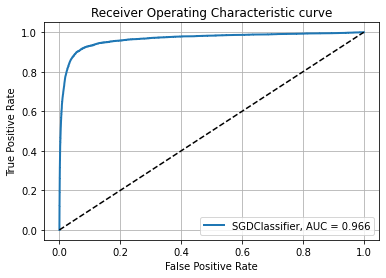

In [145]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None, ax=None):
    if not ax:
        fig, ax=plt.subplots()
    auc_score=auc(fpr, tpr)
    if label: 
        label+=", AUC = %.3f" % auc_score
    else: 
        label="AUC = %.3f" % auc_score
    ax.plot(fpr, tpr, label=label, linewidth=2)
    ax.plot([0,1], [0,1], "k--")
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="Receiver Operating Characteristic curve")
    ax.grid()
    ax.legend()

plot_roc_curve(fpr, tpr, "SGDClassifier")
plt.show()


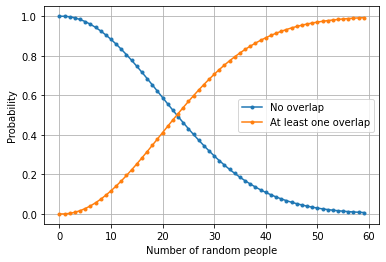

In [133]:
def prob_unmatch(n):
    prob=1
    for i in range(n):
        prob=prob*(365-i)/365
    return prob

n=np.arange(60)
m=np.array([prob_unmatch(j) for j in n])
k=1-m
fig, ax = plt.subplots()
ax.plot(n, m, marker='.', label='No overlap')
ax.plot(n, k, marker='.', label='At least one overlap')
ax.set(xlabel='Number of random people', ylabel='Probability')
ax.legend()
ax.grid()
plt.show()